# Uncertainty evaluation
We analyze the models' predictive uncertainty.

In [1]:
import string

import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cmcrameri.cm as cmc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from dask.diagnostics import ProgressBar
from matplotlib import colors
from matplotlib_inline.backend_inline import set_matplotlib_formats

import deeprec  # noqa
from deeprec import metrics
from deeprec.utils import ROOT_DIR

In [2]:
set_matplotlib_formats("retina")
plt.style.use(ROOT_DIR / "config/style_paper.mplstyle")
FIGURE_DIR = ROOT_DIR / "figures/paper"

# Register dask progress bar
ProgressBar(minimum=5).register()


In [3]:
our_store = (
    ROOT_DIR / "models/predictions/ensemble-mixed/ensemble-mixed_era_best-mae.zarr"
)
targets_store = ROOT_DIR / "data/processed/targets.zarr"
inputs_store = ROOT_DIR / "data/processed/inputs.zarr"
recs_store = ROOT_DIR / "data/processed/reconstructions.zarr"

tgts = xr.open_zarr(targets_store)
inps = xr.open_zarr(inputs_store)
our = xr.open_zarr(our_store)

pred = our.twsa
sigma = our.sigma
sigma_ale = our.sigma_ale
sigma_epi = our.sigma_epi

grace_name = "twsa_csr"

In [4]:
xr.open_dataset(ROOT_DIR / "data/raw/reconstructions/palazzoli/GRAiCE_BiLSTM.nc")

<xarray.Dataset> Size: 473MB
Dimensions:  (lat: 360, lon: 720, time: 456)
Coordinates:
  * lat      (lat) float32 1kB 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float32 3kB -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * time     (time) datetime64[ns] 4kB 1984-01-01 1984-02-01 ... 2021-12-01
Data variables:
    TWSA     (time, lat, lon) float32 473MB ...
Attributes:
    title:     TWSA reconstruction from 1984 to 2021 - BiLSTM
    subtitle:  Monthly TWSA estimates obtained with BiLSTM model (all predict...
    anything:  Monthly predictors: precipitation, snow depth water equivalent...

## Uncertainty map plot

In [5]:
# Compute mean uncertainty over time
sigma_mean = sigma.mean("time").compute()


In [6]:
# Colorbar position: right
plot_kwargs = dict(
    rasterized=True,
    coastlines=True,
    gridlines=True,
    coastlines_kwargs=dict(rasterized=True, linewidth=0.5),
    cbar_kwargs=dict(location="right", aspect=15, shrink=0.93, pad=0.03),
)


Uncertainty ratio:

$$ \frac{\sigma^2_\text{ale}}{\sigma^2_\text{epi}} $$

In [7]:
vari_ratio = (sigma_ale**2) / (sigma_epi**2)

In [8]:
vari_ratio.mean("time").compute().min()

<xarray.DataArray ()> Size: 4B
array(2.4716322, dtype=float32)

Uncertainty delta: Where did the uncertainty change the most? We substract the year-average uncertainty of 2021 from the year-average uncertainty of 2004 (the first GRACE year without missing months). We do the same for the reconstruction period

In [9]:
sigma_delta_grace = sigma.sel(time="2021").mean("time") - sigma.sel(time="2004").mean(
    "time"
)
sigma_delta_pregrace = sigma.sel(time="2001").mean("time") - sigma.sel(
    time="1941"
).mean("time")

## Create plot

In [10]:
sigma_kwargs = dict(
    vmin=0,
    vmax=120,
    cmap=cmc.lapaz_r,
    rasterized=True,
    coastlines=True,
    gridlines=True,
    add_colorbar=False,
    cbar_kwargs=None,
)
ratio_kwargs = dict(
    vmin=1,
    vmax=100,
    norm=colors.LogNorm(),
    cmap=cmc.hawaii_r,
    rasterized=True,
    coastlines=True,
    gridlines=True,
    cbar_kwargs=None,
    add_colorbar=False,
)
delta_kwargs = dict(
    vmax=100,
    cmap=cmc.vik,
    rasterized=True,
    coastlines=True,
    gridlines=True,
    cbar_kwargs=None,
    add_colorbar=False,
)


In [11]:
def calc_shrink(n: int) -> float:
    """Calculate the cbar shrink factor based on the number of plot columns"""
    SHRINK_FACTOR = 0.4
    return 1.0 - SHRINK_FACTOR / n


def calc_aspect(n: int) -> float:
    """Calculate the cbar aspect ratio based on the number of plot columns"""
    HEIGHT = 0.025
    width = calc_shrink(n) * n
    return width / HEIGHT


def calc_extendfrac(n: int) -> float:
    """Calculate the cbar extension fraction based on the number of plot columns"""
    EXTEND_FRAC = 0.05
    width = calc_shrink(n) * n
    return EXTEND_FRAC / width


# Cbar triangular extension length
EXTEND_LENGTH = 0.05

In [12]:
# Oceanic Niño Index
oni = inps.oni


In [13]:
# Calculate time series of uncertainty and RMSE
# (3 month running average similar to ONI)
sigma_tseries = (
    sigma.dr.weight_lat()
    .mean(["lat", "lon"])
    # .rolling(time=3, center=True)
    # .mean()
    .compute()
)
sigma_ale_tseries = (
    sigma_ale.dr.weight_lat()
    .mean(["lat", "lon"])
    # .rolling(time=3, center=True)
    # .mean()
    .compute()
)
sigma_epi_tseries = (
    sigma_epi.dr.weight_lat()
    .mean(["lat", "lon"])
    # .rolling(time=3, center=True)
    # .mean()
    .compute()
)
rmse_tseries = (
    metrics.rmse(
        tgts[grace_name],
        pred,
        dim=[],
    )
    .dr.weight_lat()
    .mean(["lat", "lon"])
    # .rolling(time=3, center=True, min_periods=1)
    # .mean()
    .compute()
)

In [14]:
# Open Rodell et al. (2023) TWS intensity time series data
rodell_df = pd.read_excel(
    ROOT_DIR / "data/raw/inputs/intensity/rodell/Figure2_data.xlsx",
    sheet_name="Total_Intensity&GISTemp",
    usecols=[0, 1, 2],
).replace(-9999.0, np.nan)
rodell_df = rodell_df.rename(
    columns=dict(zip(rodell_df.columns, ["date", "intensity", "gis_temp"]))
).set_index("date")
rodell_df

ints_tseries = xr.DataArray.from_series(rodell_df.intensity).rename(date="time") / 1e3


In [15]:
REC_START = pd.Timestamp("1940-01-01")
REC_END = pd.Timestamp("2024-01-01")
GRACE_OG_START = pd.Timestamp("2002-03-01")
GRACE_OG_END = pd.Timestamp("2017-01-01")
GRACE_FO_START = pd.Timestamp("2018-11-01")
GRACE_FO_END = REC_END
TRAIN_END = pd.Timestamp("2021-12-01")

In [16]:
from matplotlib.patches import ConnectionPatch
from matplotlib.dates import date2num

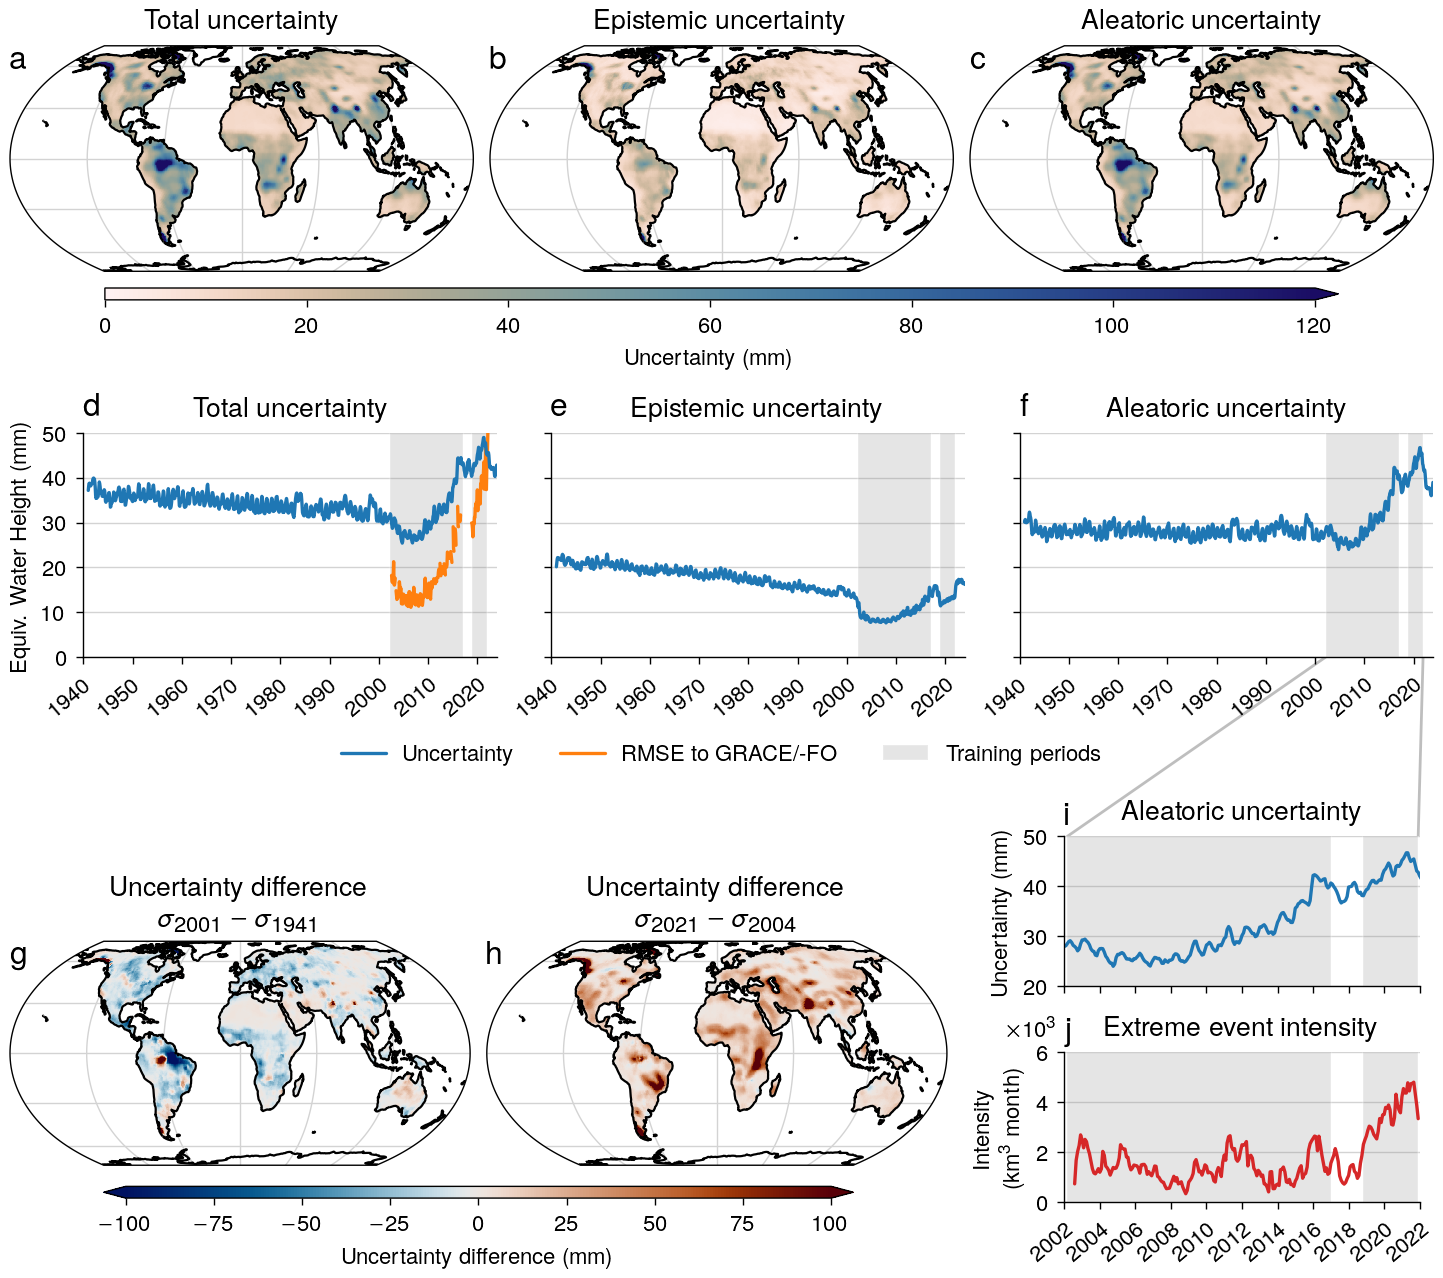

In [17]:
### Layout ###

fig = plt.figure(figsize=(7.2, 6.5))
gs = fig.add_gridspec(4, 3, height_ratios=[5, 5, 3, 3])
sfig1 = fig.add_subfigure(gs[0, :])
sfig2 = fig.add_subfigure(gs[1, :])
sfig3 = fig.add_subfigure(gs[2:, 0:2])
sfig4 = fig.add_subfigure(gs[2:, 2:])

axs_sfig1 = sfig1.subplots(1, 3, subplot_kw={"projection": ccrs.EqualEarth()})
axs_sfig2 = sfig2.subplots(1, 3, sharex=True, sharey=True)
axs_sfig3 = sfig3.subplots(1, 2, subplot_kw={"projection": ccrs.EqualEarth()})
axs_sfig4 = sfig4.subplots(2, 1, sharex=True)


### Uncertainty components map plots ###
p_sigma = sigma.mean("time").dr.projplot(ax=axs_sfig1[0], **sigma_kwargs)
sigma_epi.mean("time").dr.projplot(ax=axs_sfig1[1], **sigma_kwargs)
sigma_ale.mean("time").dr.projplot(ax=axs_sfig1[2], **sigma_kwargs)

# Titles
axs_sfig1[0].set(title="Total uncertainty")
axs_sfig1[1].set(title="Epistemic uncertainty")
axs_sfig1[2].set(title="Aleatoric uncertainty")

# Colorbar
sfig1.colorbar(
    p_sigma,
    ax=axs_sfig1,
    label="Uncertainty (mm)",
    location="bottom",
    aspect=calc_aspect(3),
    shrink=calc_shrink(3),
    extendfrac=calc_extendfrac(3),
    extend="max",
)

### Uncertainty components timeseries ###

sigma_color = "tab:blue"
rmse_color = "tab:orange"
(p_rmse_ts,) = rmse_tseries.plot(ax=axs_sfig2[0], color=rmse_color)
(p_sigma_ts,) = sigma_tseries.plot(ax=axs_sfig2[0], color=sigma_color)
sigma_epi_tseries.plot(ax=axs_sfig2[1], color=sigma_color)
sigma_ale_tseries.plot(ax=axs_sfig2[2], color=sigma_color)

axs_sfig2[0].set(
    ylim=(0, 50),
    title="Total uncertainty",
    xlabel=None,
    xlim=(REC_START, REC_END),
)
axs_sfig2[0].set(ylabel="Equiv. Water Height (mm)")
axs_sfig2[1].set(title="Epistemic uncertainty", xlabel=None, ylabel=None)
axs_sfig2[2].set(title="Aleatoric uncertainty", xlabel=None, ylabel=None)

# Mark training periods
for ax in [*axs_sfig2, *axs_sfig4]:
    # OG GRACE
    box = ax.axvspan(
        GRACE_OG_START,
        GRACE_OG_END,
        facecolor="tab:gray",
        alpha=0.2,
    )
    # GRACE-FO
    ax.axvspan(
        GRACE_FO_START,
        TRAIN_END,
        facecolor="tab:gray",
        alpha=0.2,
    )

# Add legend
handles = [p_sigma_ts, p_rmse_ts, box]
labels = [
    "Uncertainty",
    "RMSE to GRACE/-FO",
    "Training periods",
]
sfig2.legend(handles, labels, loc="outside lower center", ncol=len(handles))

### Uncertainty delta ###

p_delta = sigma_delta_pregrace.dr.projplot(ax=axs_sfig3[0], **delta_kwargs)
sigma_delta_grace.dr.projplot(ax=axs_sfig3[1], **delta_kwargs)

axs_sfig3[0].set(
    title="Uncertainty difference\n" + r"$\sigma_\text{2001}-\sigma_\text{1941}$"
)
axs_sfig3[1].set(
    title="Uncertainty difference\n" + r"$\sigma_\text{2021}-\sigma_\text{2004}$"
)

sfig3.colorbar(
    p_delta,
    ax=axs_sfig3,
    label="Uncertainty difference (mm)",
    location="bottom",
    aspect=calc_aspect(2),
    shrink=calc_shrink(2),
    extendfrac=calc_extendfrac(2),
    extend="both",
)

### GRACE period zoom in ###

# Aleatoric uncertainty
sigma_ale_tseries.plot(ax=axs_sfig4[0])
axs_sfig4[0].set(
    xlabel=None,
    ylabel="Uncertainty (mm)",
    ylim=(20, 50),
    title="Aleatoric uncertainty",
    xlim=(pd.Timestamp("2002-01-01"), pd.Timestamp("2022-01-01")),
)

# Intensity
ints_tseries.plot(ax=axs_sfig4[1], color="tab:red")
axs_sfig4[1].set(
    xlabel=None,
    ylabel="Intensity\n(km$^3$ month)",
    ylim=(0, 6),
    title="Extreme event intensity",
)

# Time series axes formatting
for ax in [*axs_sfig2, *axs_sfig4]:
    ax.label_outer()
    ax.yaxis.grid()
    # Rotates and right-aligns the x labels so they don't crowd each other.
    for label in ax.get_xticklabels():
        label.set(rotation=40, rotation_mode="anchor", ha="right")

# Add connections
con_kwargs = dict(
    color="tab:gray",
    alpha=0.5,
    linewidth=1.0,
    zorder=0,
    coordsA=axs_sfig2[2].transData,
    coordsB=axs_sfig4[0].transData,
)
# Connect from axs_sfig2[2] to axs_sfig4[0]
con1 = ConnectionPatch(
    xyA=(date2num(GRACE_OG_START), 0), xyB=(date2num(GRACE_OG_START), 50), **con_kwargs
)
con2 = ConnectionPatch(
    xyA=(date2num(TRAIN_END), 0), xyB=(date2num(TRAIN_END), 50), **con_kwargs
)
fig.add_artist(con1)
fig.add_artist(con2)

# Add x10^3 text near the y-axis
axs_sfig4[1].text(
    -0.02,
    1.1,
    r"$\times 10^3$",
    transform=axs_sfig4[1].transAxes,
    # va="center",
    ha="right",
    fontsize="medium",
)

### Add letters ###
for n, ax in enumerate([*axs_sfig1, *axs_sfig2, *axs_sfig3, *axs_sfig4]):
    # Adjust spacing based on axis type
    y = (1.0 - 0.1) if isinstance(ax, GeoAxes) else (1.0 + 0.08)
    ax.text(
        x=0,
        y=y,
        s=string.ascii_lowercase[n],
        transform=ax.transAxes,
        size="x-large",
        weight="bold",
    )

fig.savefig(FIGURE_DIR / "uncertainty.pdf", backend="pgf")